In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, add
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

def load_and_preprocess_images(folder, target_size=(256, 256)):
    images = []
    filenames = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            resized_img = cv2.resize(img, target_size)
            images.append(resized_img)
            filenames.append(filename)
    return images, filenames

# Load and preprocess images and labels
train_images, image_filenames = load_and_preprocess_images("C:/Users/srini/OneDrive - Amrita vishwa vidyapeetham/Desktop/training/images/")
train_labels, label_filenames = load_and_preprocess_images("C:/Users/srini/OneDrive - Amrita vishwa vidyapeetham/Desktop/training/labels/")

# Ensure that images and labels are matched correctly
assert image_filenames == label_filenames, "Mismatch between image and label files"

# Convert lists to numpy arrays for easier manipulation
train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Normalize pixel values
train_images = train_images / 255.0
train_labels = np.where(train_labels > 0, 1, 0).astype(np.float32)  # Binarize labels and convert to float32

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Reshape for the neural network (e.g., adding channel dimension for grayscale images)
X_train = np.expand_dims(X_train, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

def dice_coefficient(y_true, y_pred):
    smooth = 1.0
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def iou(y_true, y_pred):
    smooth = 1.0
    intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true * y_pred), axis=[1, 2, 3])
    union = tf.keras.backend.sum(y_true, [1, 2, 3]) + tf.keras.backend.sum(y_pred, [1, 2, 3]) - intersection
    return tf.keras.backend.mean((intersection + smooth) / (union + smooth), axis=0)

def precision(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, activation='relu', padding='same')(inputs)
    x = Conv2D(num_filters, 3, activation='relu', padding='same')(x)
    return x

def unetpp_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    
    # Encoder
    c1 = conv_block(inputs, 64)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)

    c2 = conv_block(p1, 128)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)

    c3 = conv_block(p2, 256)
    p3 = MaxPooling2D(pool_size=(2, 2))(c3)

    c4 = conv_block(p3, 512)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = conv_block(p4, 1024)

    # Decoder
    u6 = UpSampling2D(size=(2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = conv_block(u6, 512)

    u7 = UpSampling2D(size=(2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = conv_block(u7, 256)

    u8 = UpSampling2D(size=(2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = conv_block(u8, 128)

    u9 = UpSampling2D(size=(2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = conv_block(u9, 64)

    outputs = Conv2D(1, 1, activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy', dice_coefficient, iou, precision, recall, f1_score])
    
    return model

# Create the model
model = unetpp_model()
model.summary()

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=100, 
                    batch_size=16, 
                    verbose=1,
                    callbacks=[early_stopping])

# Check if early stopping was triggered
if len(history.history['val_loss']) < 100:
    print("Early stopping was triggered. Training stopped early.")
else:
    print("Training completed without early stopping.")

# Save the model
model.save("unetpp_model.h5")
print("Model saved as unetpp_model.h5")


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │        640 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_23[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_6[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │  2,359,808 │ conv2d_25[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_7[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 16, 16,    │  9,438,208 │ conv2d_27[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 32, 32,    │          0 │ conv2d_28[0][0]   │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 32, 32,    │          0 │ up_sampling2d_4[

 Total params: 31,377,793 (119.70 MB)

 Trainable params: 31,377,793 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 30s 8s/step - accuracy: 0.5044 - dice_coefficient: 0.4470 - f1_score: 0.4784 - iou: 0.2779 - loss: 0.6944 - precision: 0.4626 - recall: 0.6517 - val_accuracy: 0.5459 - val_dice_coefficient: 0.4706 - val_f1_score: 0.0050 - val_iou: 0.3054 - val_loss: 0.6924 - val_precision: 0.9713 - val_recall: 0.0025
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.6247 - dice_coefficient: 0.3380 - f1_score: 0.0037 - iou: 0.2034 - loss: 0.8370 - precision: 0.6927 - recall: 0.0019 - val_accuracy: 0.6297 - val_dice_coefficient: 0.4766 - val_f1_score: 0.3157 - val_iou: 0.3106 - val_loss: 0.6901 - val_precision: 0.9946 - val_recall: 0.1876
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 8s/step - accuracy: 0.7550 - dice_coefficient: 0.4394 - f1_score: 0.5383 - iou: 0.2702 - loss: 0.6892 - precision: 0.9778 - recall: 0.4267 - val_accuracy: 0.8842 - val_dice_coefficient: 0.4796 - val_f1_score: 0.8598 - val_iou: 0.3131 - val_loss: 0.6865 - val_precision: 0.9579 - va

Early stopping was triggered. Training stopped early.
Model saved as unetpp_model.h5


In [3]:
# Print the final metrics
final_metrics = {
    "accuracy": history.history['accuracy'][-1],
    "val_accuracy": history.history['val_accuracy'][-1],
    "loss": history.history['loss'][-1],
    "val_loss": history.history['val_loss'][-1],
    "dice_coefficient": history.history['dice_coefficient'][-1],
    "val_dice_coefficient": history.history['val_dice_coefficient'][-1],
    "iou": history.history['iou'][-1],
    "val_iou": history.history['val_iou'][-1],
    "precision": history.history['precision'][-1],
    "val_precision": history.history['val_precision'][-1],
    "recall": history.history['recall'][-1],
    "val_recall": history.history['val_recall'][-1],
    "f1_score": history.history['f1_score'][-1],
    "val_f1_score": history.history['val_f1_score'][-1]
}

for metric, value in final_metrics.items():
    print(f"{metric}: {value}")

accuracy: 0.9586231112480164
val_accuracy: 0.9563125371932983
loss: 0.10121377557516098
val_loss: 0.11027977615594864
dice_coefficient: 0.9211216568946838
val_dice_coefficient: 0.9309253692626953
iou: 0.8408722281455994
val_iou: 0.8706162571907043
precision: 0.960963249206543
val_precision: 0.9492813944816589
recall: 0.932750940322876
val_recall: 0.9550626873970032
f1_score: 0.9463626742362976
val_f1_score: 0.9521632194519043


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


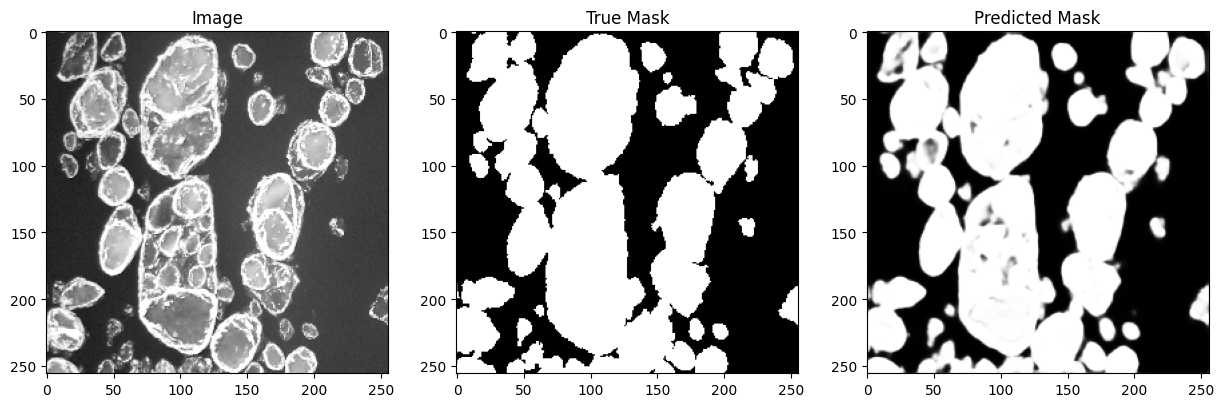

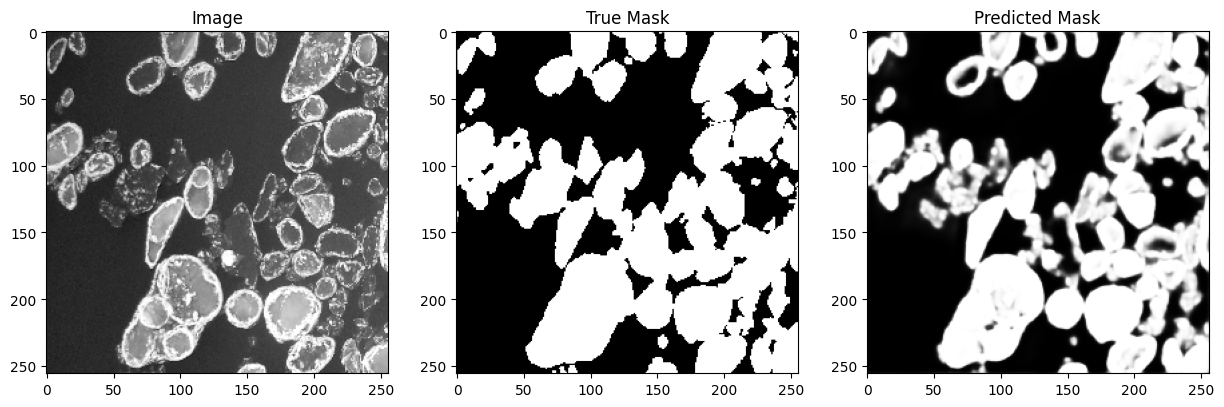

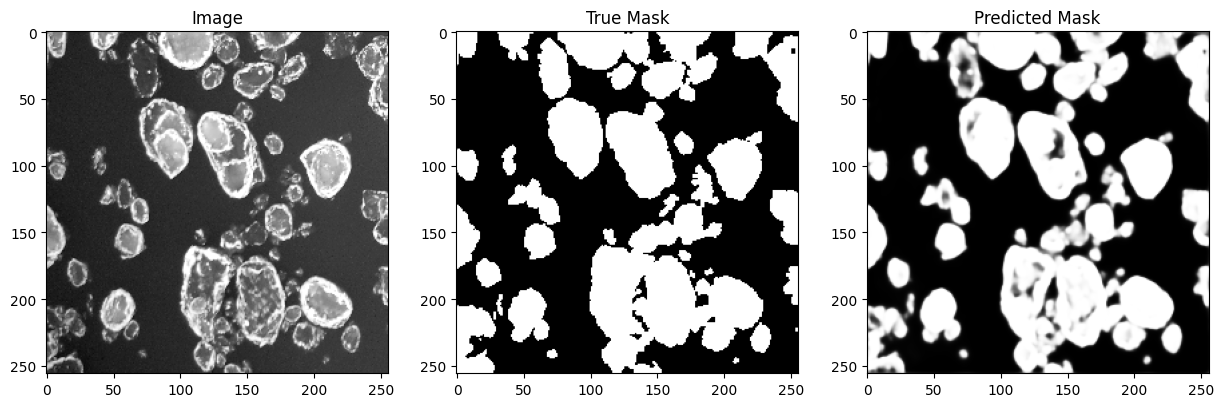

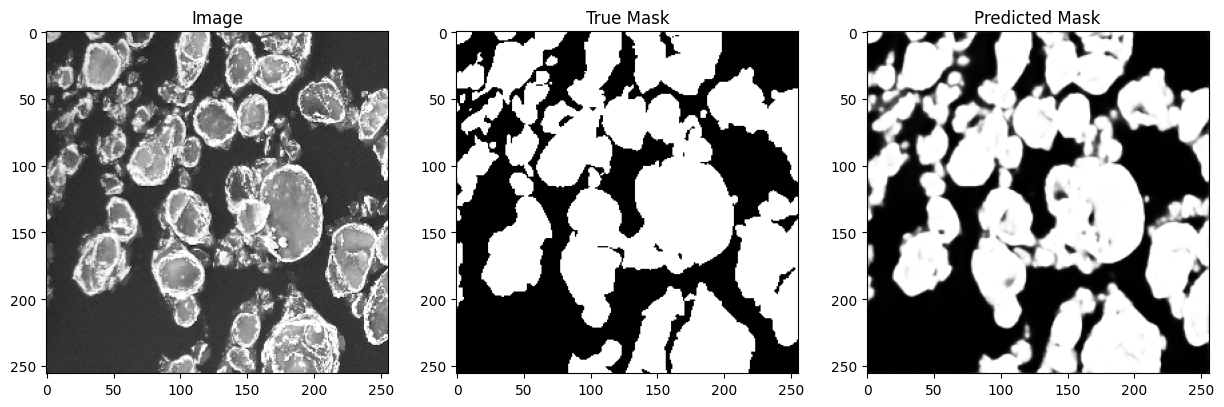

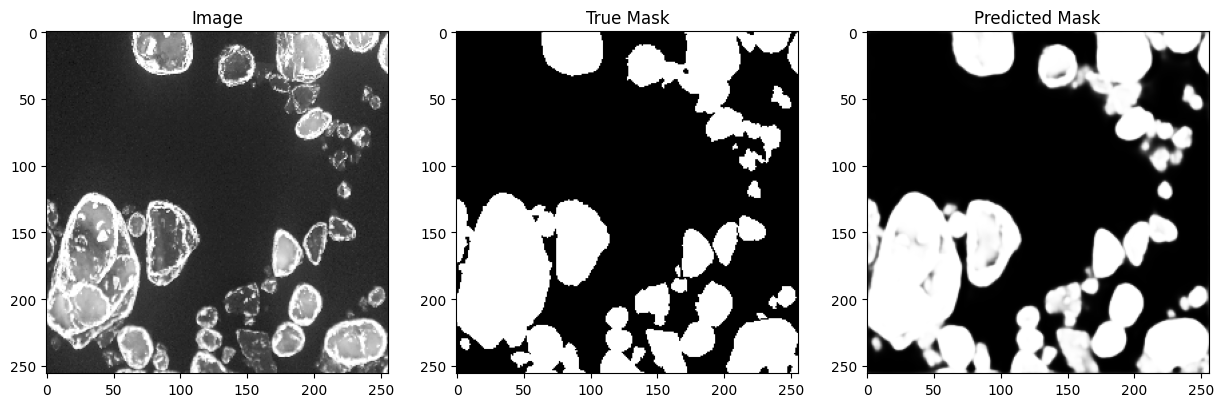

In [4]:
# Predict segmentation masks for validation images
predicted_masks = model.predict(X_val)

# Plotting some results
import matplotlib.pyplot as plt

def plot_results(img, true_mask, pred_mask):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Image')
    plt.imshow(img.squeeze(), cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title('True Mask')
    plt.imshow(true_mask.squeeze(), cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(pred_mask.squeeze(), cmap='gray')
    plt.show()

# Visualize some results
for i in range(5):  # Plot first 5 results
    plot_results(X_val[i], y_val[i], predicted_masks[i])

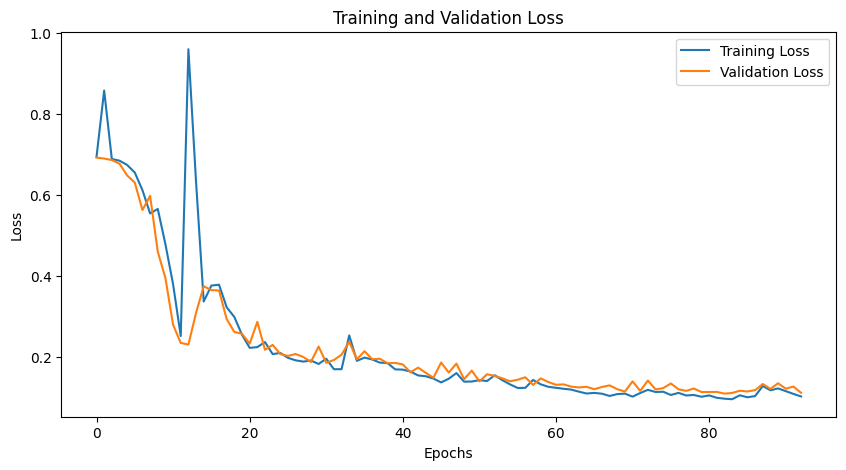

In [5]:
# Plot the loss graph
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()